# This notebook processes two sets of raw data for later analysis
## 1. MTA NYCT Bus Data
- The data is downloaded with [fetchbus.py](https://github.com/ywnch/NYC-bus-LTT-prediction/blob/master/fetchbus.py) from MTA SIRI API.
- Training Data Time Range: 2018/04/06 to 2018/04/12 and 16:00 to 20:00 (evening peak for a week)
- Training Data Space Range: "5 AV/EAST 96 ST" to "5 AV/W 36 ST" (CallDistanceAlongRoute: 4632.77 ~ 9554.96)
- Training Data Direction: Southbound (DirectionRef: 1)

## 2. MiM Traffic Flow Data
- Manually downloaded from [NYC DOT website](http://flowmap.nyctmc.org/weborb4/flowmap/)
- Time Range: same as above
- Space Range: same as above
- See metadata documented [here](https://github.com/ywnch/NYC-bus-LTT-prediction/blob/master/data/traffic-metadata.csv)
- The only variable is travel time

## Variables for MTA NYCT Bus Data
### Manually generated:
- DayOfWeek - 1: Monday; 7: Sunday
- VehicleDistanceAlongRoute - The distance of the vehicle from the beginning of the trip/route in meters. ("CallDistanceAlongRoute" minus "DistanceFromCall")

### API variables:
- Bearing – Vehicle bearing: 0 is East, increments counter-clockwise.
- BlockRef – Depending on the system’s level of confidence, the GTFS block_id the bus is serving. Please see “Transparency of Block vs. Trip-Level Assignment”.
- CallDistanceAlongRoute -The distance of the stop from the beginning of the trip/route in meters.
- DataFrameRef – The GTFS service date for the trip the vehicle is serving.
- DatedVehicleJourneyRef – The GTFS trip ID for trip the vehicle is serving, preceeded by the GTFS agency ID.
- DestinationRef – The GTFS stop ID for the last stop on the trip the vehicle is serving, prefixed by Agency ID.
- DirectionRef – The GTFS direction for the trip the vehicle is serving.
- DistanceFromCall – The distance from the vehicle to the stop along the route, in meters.
- Distances – The MTA Bus Time extensions to show distance of the vehicle from the stop.
- Extensions – SIRI container for extensions to the standard.
- FramedVehicleJourneyRef – A compound element uniquely identifying the trip the vehicle is serving.
- JourneyPatternRef – The GTFS Shape ID, prefixed by GTFS Agency ID.
- LineRef – The ‘fully qualified’ route name (GTFS agency ID + route ID) for the trip the vehicle is serving. Not intended to be customer-facing.
- Monitored – Always true.
- MonitoredCall – Call data about a particular stop. In StopMonitoring, it is the stop of interest, in VehicleMonitoring it is the next stop the bus will make.
- MonitoredStopVisit– SIRI container for data about a particular vehicle servicing the selected stop.
- MonitoredVehicleJourney – A MonitoredVehicleJourney element for a vehicle in revenue service. Please See the MonitoredVehicleJourney page for a thorough discription.
- OnwardCall – A stop that the vehicle is going to make.
- OnwardCalls – The collection of calls that a vehicle is going to make.
- OperatorRef – GTFS Agency_ID.
- OriginAimedDepartureTime – OriginAimedDepartureTime indicates the scheduled departure time of that bus from that terminal in ISO8601 format.
- OriginRef -The GTFS stop ID for the first stop on the trip the vehicle is serving, prefixed by Agency ID
- PresentableDistance -The distance displayed in the UI, see below for an additional info.
- ProgressRate – Indicator of whether the bus is making progress (i.e. moving, generally), not moving (with value noProgress), laying over before beginning a trip (value layover), or serving a trip prior to one which will arrive (prevTrip).
- ProgressStatus – Optional indicator of vehicle progress status. Set to “layover” when the bus is in a layover waiting for its next trip to start at a terminal, and/or “prevTrip” when the bus is currently serving the previous trip and the information presented ‘wraps around’ to the following scheduled trip.
- PublishedLineName – The GTFS route_short_name.
- RecordedAtTime – The timestamp of the last real-time update from the particular vehicle.
- ResponseTimestamp – The timestamp on the MTA Bus Time server at the time the request was fulfilled.
- SituationExchangeDelivery – The SIRI SituationExchangeDelivery element only appears when there is a service alert active for a route or stop being called on. It is used by the responses to both the VehicleMonitoring and StopMonitoring calls.
- SituationRef – SituationRef, present only if there is an active service alert covering this call.
- StopMonitoringDelivery – SIRI container for VehicleMonitoring response data
- StopPointName – The GTFS stop name of the stop.
- StopPointRef – The GTFS stop ID of the stop prefixed by agency_id.
- StopsFromCall – The number of stops on the vehicle’s current trip until the stop in question, starting from 0.
- ValidUntil – The time until which the response data is valid until.
- VehicleActivity – SIRI container for data about a particular vehicle.
- VehicleLocation – The most recently recorded or inferred coordinates of this vehicle.
- VehicleMonitoringDelivery – SIRI container for VehicleMonitoring response data.
- VehicleRef – The vehicle ID, preceded by the GTFS agency ID.
- VisitNumber – The ordinal value of the visit of this vehicle to this stop, always 1 in this implementation.

#### Transparency of Block vs. Trip-Level Assignment:

MTA Bus Time tries to assign buses to blocks- a sequence of trips that start and end at a depot. This allows the system to make a statement about what a bus will do after it reaches the end of its current trip.

However, there is not always enough affirmative and corresponding evidence to make such a strong statement. In this case, MTA Bus Time falls back to a trip-level assignment, where it just picks a trip from the schedule that is representative of the route and stopping pattern that the bus is likely to pursue.

The SIRI API now reflects this distinction as described here and in other items below. If the assignment is block-level, the new BlockRef field of the MonitoredVehicleJourney is present, and populated with the assigned block id.

#### The PresentableDistance field:

the logic that determines whether stops or miles are shown in the PresentableDistance field is below:

show distance in miles if and only if:
(distance in miles to _immediate next stop_ is > D) OR (distance in stops to current stop is > N AND distance in miles to current stop > E)
in other words, show distance in stops if and only if (the below is just the inverse of the above, according to DeMorgan’s law):
(distance in miles to _immediate next stop_ is <= D) AND (distance in stops to current stop <= N OR distance in miles to current stop <= E)
Show “approaching” if and only if:
distance_in_miles to immediate next stop < P
show “at stop” if and only if:
distance_in_miles to immediate next stop < T
Current Parameter Values:

Parameter Value (Note that distances in the data are in **METERS**)
- D .5 miles
- N 3 stops
- E .5 miles
- P 500 feet
- T 100 feet

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1. MTA NYCT Bus Data

In [13]:
# raw data
# fnames = ["data/M1-Fri-180406-154257-260.csv",
#           "data/M1-Sat-180407-154620-260.csv",
#           "data/M1-Sun-180408-155956-250.csv",
#           "data/M1-Mon-180409-155534-250.csv",
#           "data/M1-Tue-180410-154415-260.csv",
#           "data/M1-Wed-180411-155909-250.csv",
#           "data/M1-Thu-180412-154116-260.csv"]

fnames = ["data/M1-Fri-180406-154257-260.csv",
          "data/M1-Fri-180413-160429-240.csv",
          "data/M1-Fri-180420-154308-260.csv",
          "data/M1-Fri-180427-153122-270.csv",
          "data/M1-Mon-180409-155534-250.csv",
          "data/M1-Mon-180416-174106-140.csv",
          "data/M1-Mon-180423-154223-260.csv",
          "data/M1-Mon-180430-161834-240.csv",
          "data/M1-Sat-180407-154620-260.csv",
          "data/M1-Sat-180414-161359-240.csv",
          "data/M1-Sat-180421-154208-260.csv",
          "data/M1-Sun-180408-155956-250.csv",
          "data/M1-Sun-180415-154207-260.csv",
          "data/M1-Sun-180422-161320-240.csv",
          "data/M1-Sun-180429-153058-270.csv",
          "data/M1-Thu-180412-154116-260.csv",
          "data/M1-Thu-180419-154330-260.csv",
          "data/M1-Thu-180426-155236-250.csv",
          "data/M1-Tue-180410-154415-260.csv",
          "data/M1-Tue-180417-155229-250.csv",
          "data/M1-Tue-180424-160342-240.csv",
          "data/M1-Tue-180501-154017-260.csv",
          "data/M1-Wed-180411-155909-250.csv"]

In [5]:
meta = pd.read_csv("data/traffic-metadata.csv")
meta

,ID,from,to,segment,meter,feet
0,188189,188,189,5th Avenue - Southbound - 96th St to 86th St,811.76,2663.22
1,18922,189,22,5th Avenue - Southbound - 86th St to 72nd St,1153.06,3782.96
2,2216,22,16,5th Avenue - Southbound - 72nd St to 57th St,1207.64,3962.03
3,1615,16,15,5th Avenue - Southbound - 57th St to 49th St,642.36,2107.45
4,1514,15,14,5th Avenue - Southbound - 49th St to 42nd St,564.20,1851.03
5,14118,14,118,5th Avenue - Southbound - 42nd St to 34th St,642.87,2109.13


In [6]:
# dictionary for segment id mapping
seg_id = {1:188189,
          2:18922,
          3:2216,
          4:1615,
          5:1514,
          6:14118}

# calculate cutpoints of MiM segments
cutpts = []
start = 4668 # E 96th St intersection

cutpts.append(start)
for m in meta['meter']:
    start += m
    cutpts.append(start)
    
cutpts

[4668, 5479.76, 6632.82, 7840.46, 8482.82, 9047.02, 9689.890000000001]

In [7]:
# assign segment id a bus location is in based on VehicleDistanceAlongRoute(VDAR)
def segment(vdar):
    i = 0
    while vdar >= cutpts[i]:
        i += 1
    return seg_id[i]

In [8]:
def split_dh(df):
    """ split deadheads for different trips made by same vehicle """
    dfs = []
    for v in df['VehicleRef'].unique():       
        
        trip = 1 # start with trip no. 1
        NewVehicleRef = [] # include initial one for the first record?: v + '_' + str(trip)
        
        test = df[df['VehicleRef'] == v].sort_index()
        
        for boo in list(test['CallDistanceAlongRoute'].diff() < -4000):
            if boo: # if this is a new trip (which jumps back 4 km)
                trip += 1 # assign new trip no.
            NewVehicleRef.append(v + '_' + str(trip)) # each iteration, append new vehicle ref
        
        test['NewVehicleRef'] = NewVehicleRef
        dfs.append(test)
    df_all = pd.concat(dfs)
    return df_all

In [9]:
# all the data processing
def process(fname):
    """
    Subset M1 data for 16:00 - 20:00, southbound,
    and between E 94 - W 36 on 5 Av.
    """
    
    # read fetchbus output dataframe
    df = pd.read_csv(fname, index_col=0)
    
    # subset for direction 1
    df = df[df['DirectionRef'] == 1]
    
    # convert to local timezone
    df['Timestamp'] = pd.to_datetime(df['RecordedAtTime']) \
                        .dt.tz_localize('UTC') \
                        .dt.tz_convert('America/New_York')

    # generate day of week variable (1: Monday)
    df['DayOfWeek'] = df['Timestamp'].dt.dayofweek + 1
    df['Holiday'] = df['DayOfWeek'] // 6 ### right now this only capture weekends ###

    # generate an indicator for whether exclusive bus lane on 5th Av is active
    # 7 am to 7 pm from Mon to Fri
    df['BusLane'] = (df['DayOfWeek'] < 6) & (df['Timestamp'].dt.hour >= 7) & (df['Timestamp'].dt.hour < 19)

    # set timestamp as index and subset within 1600 to 2000 time window
    df = df.set_index('Timestamp').between_time('16:00', '20:00')

    # calculate vehicle distance
    df['VehicleDistanceAlongRoute'] = df['CallDistanceAlongRoute'] - df['DistanceFromCall']
    
    # subset for MiM data available segement (4633+35:9555)
    df = df[(df['VehicleDistanceAlongRoute'] > 4668) & (df['VehicleDistanceAlongRoute'] < 9555)]
    
    # calculate the segment id
    df['Segment'] = list(map(segment, df['VehicleDistanceAlongRoute']))
  
    # sort dataframe
    df.sort_index(inplace=True)
    
    # split multiple trips by same vehicle
    df = split_dh(df)
    
    # return df
    return df

In [15]:
dfs = []

# save individual modified data
for i, f in enumerate(fnames):
    df = process(f)
    dfs.append(df)
    df.to_csv("data/M1-%s.csv"%(f[12:18]))

# concat all data into a single file as well
df_all = pd.concat(dfs)
df_all.to_csv("M1-train.csv")

In [16]:
df_all.head()

,Bearing,BlockRef,CallDistanceAlongRoute,DataFrameRef,DatedVehicleJourneyRef,DestinationName,DestinationRef,DirectionRef,DistanceFromCall,ExpectedArrivalTime,...,StopPointRef,StopsFromCall,VehicleRef,VisitNumber,DayOfWeek,Holiday,BusLane,VehicleDistanceAlongRoute,Segment,NewVehicleRef
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-06 16:00:01-04:00,233.35362,MTA NYCT_OF_B8-Weekday_C_OF_29220_M1-122,5169.49,2018-04-06,MTA NYCT_OF_B8-Weekday-092900_M1_145,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,23.58,2018-04-06T16:00:18.763-04:00,...,MTA_400117,0,MTA NYCT_3891,1,5,0,True,5145.91,188189,MTA NYCT_3891_1
2018-04-06 16:00:32-04:00,233.91893,MTA NYCT_OF_B8-Weekday_C_OF_29220_M1-122,5398.92,2018-04-06,MTA NYCT_OF_B8-Weekday-092900_M1_145,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,107.21,2018-04-06T16:01:04.174-04:00,...,MTA_400118,0,MTA NYCT_3891,1,5,0,True,5291.71,188189,MTA NYCT_3891_1
2018-04-06 16:01:04-04:00,233.91893,MTA NYCT_OF_B8-Weekday_C_OF_29220_M1-122,5398.92,2018-04-06,MTA NYCT_OF_B8-Weekday-092900_M1_145,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,105.06,2018-04-06T16:01:35.531-04:00,...,MTA_400118,0,MTA NYCT_3891,1,5,0,True,5293.86,188189,MTA NYCT_3891_1
2018-04-06 16:01:34-04:00,234.37209,MTA NYCT_OF_B8-Weekday_C_OF_29220_M1-122,5398.92,2018-04-06,MTA NYCT_OF_B8-Weekday-092900_M1_145,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,4.29,2018-04-06T16:01:50.607-04:00,...,MTA_400118,0,MTA NYCT_3891,1,5,0,True,5394.63,188189,MTA NYCT_3891_1
2018-04-06 16:02:06-04:00,233.95068,MTA NYCT_OF_B8-Weekday_C_OF_29220_M1-122,5621.35,2018-04-06,MTA NYCT_OF_B8-Weekday-092900_M1_145,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,203.00,2018-04-06T16:04:10.481-04:00,...,MTA_400119,0,MTA NYCT_3891,1,5,0,True,5418.35,188189,MTA NYCT_3891_1


### Deadhead Removal!

In [127]:
df = process("data/M1-Fri-180406-154257-260.csv")
dff = split_dh(df)

In [133]:
from fetchbus import plot_tsd

# plot tsd with NewVehicleRef
def plot_tsd_new(df, dir_ref=0, start_min=None, end_min=None, save=False, fname='TSD'):
    # determine time interval to be plotted
    try:
        s = start_min * 2 # * 60 sec / 30 sec interval
        e = end_min * 2
    except:
        s = start_min
        e = end_min
    
    # subset df for given direction
    df = df[df['DirectionRef'] == dir_ref]
    
    # convert time format
    df['RecordedAtTime'] = pd.to_datetime(df['RecordedAtTime'])

    # plot figure
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    
    # calculate vehicle distance along the route
    df['VehDistAlongRoute'] = df['CallDistanceAlongRoute'] - df['DistanceFromCall']
    
    # plot the trajectory for each vehicle
    for i, v in enumerate(df['NewVehicleRef'].unique()):
        # subset data for single vehicle
        veh_df = df[df['NewVehicleRef'] == v]
        # subset within specified time window
        veh_df = veh_df.iloc[s:e,:]
        
        # plot CallDistanceAlongRoute (bus stops)
        [ax.plot([df['RecordedAtTime'].min(), df['RecordedAtTime'].max()], [i, i], color='gray', alpha=0.1) for i in df['CallDistanceAlongRoute'].unique()]
        
        ax.plot(veh_df['RecordedAtTime'], veh_df['VehDistAlongRoute'], marker='.')
        ax.annotate('%s'%v.split("_")[1], (list(veh_df['RecordedAtTime'])[0],list(veh_df['VehDistAlongRoute'])[0]))
        
        ax.grid()
        ax.set_xlabel("time", fontsize=14)
        ax.set_ylabel("distance along route (m)", fontsize=14)
        ax.set_title("Time-space Diagram", fontsize=18)
    
    plt.tight_layout()
    
    # save figure locally if specified
    if save:
        plt.savefig("%s.png"%(fname), dpi=300)
    else:
        pass
    plt.show()
    
    return fig, ax

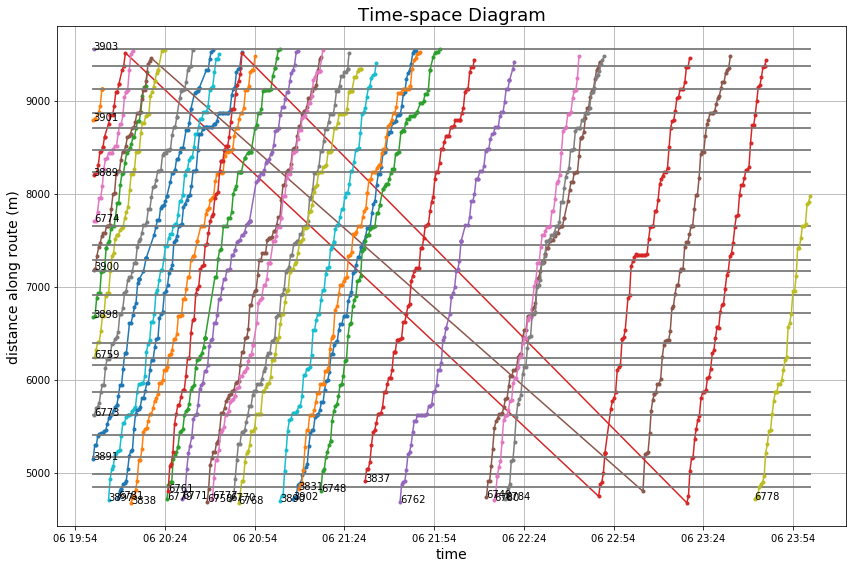

(<matplotlib.figure.Figure at 0x118fee6d8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11c7aad30>)

In [129]:
plot_tsd(df, dir_ref=1)

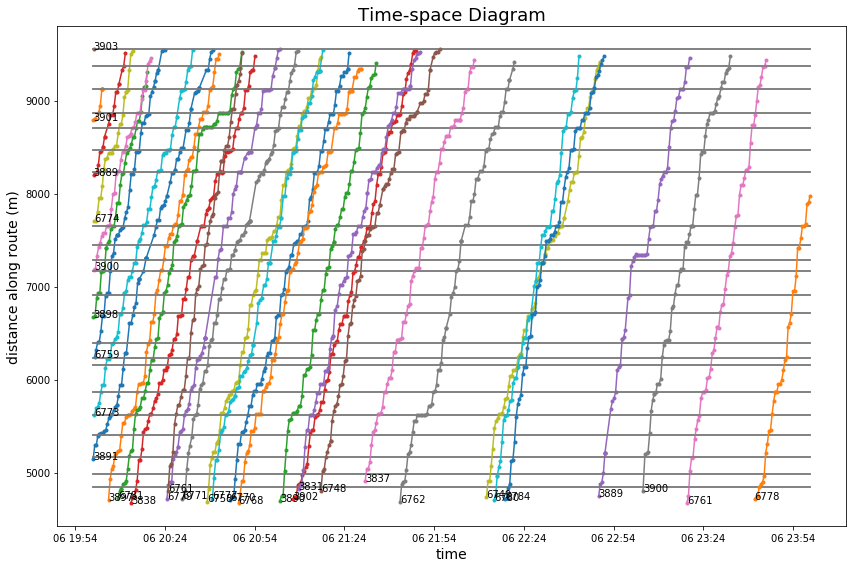

(<matplotlib.figure.Figure at 0x11d8f6198>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11dadb2b0>)

In [132]:
plot_tsd(dff, dir_ref=1)

## 2. MiM Traffic Flow Data

In [6]:
# read metadata of segment info
metadata = pd.read_csv("data/traffic-metadata.csv")
metadata

,ID,from,to,segment,meter,feet
0,188189,188,189,5th Avenue - Southbound - 96th St to 86th St,811.76,2663.22
1,18922,189,22,5th Avenue - Southbound - 86th St to 72nd St,1153.06,3782.96
2,2216,22,16,5th Avenue - Southbound - 72nd St to 57th St,1207.64,3962.03
3,1615,16,15,5th Avenue - Southbound - 57th St to 49th St,642.36,2107.45
4,1514,15,14,5th Avenue - Southbound - 49th St to 42nd St,564.20,1851.03
5,14118,14,118,5th Avenue - Southbound - 42nd St to 34th St,642.87,2109.13


In [7]:
dfs = []

# add segment ID to each data file
for i, n in enumerate(metadata['ID']):
    for d in range(7):
        df = pd.read_csv("data/%s_mim_data_04_%02d_18.csv"%(n, 6+d))
        df['ID'] = n
        dfs.append(df)

# concat all data
df_all = pd.concat(dfs)

# drop duplicates of same datetime at the same segment (keep the latest record)
df_all.drop_duplicates(['Date', 'time', 'ID'], keep='last', inplace=True)

# save into a single file
df_all.reset_index(drop=True, inplace=True)
df_all.to_csv("mim-train.csv")

In [8]:
df_all.head()

,uid,Date,time,travelTime,ID
0,1352824837,04-06-18,16:00:00,320,188189
1,1352825102,04-06-18,16:00:15,275,188189
2,1352825304,04-06-18,16:00:27,180,188189
3,1352826723,04-06-18,16:01:58,184,188189
4,1352827945,04-06-18,16:03:11,243,188189


## Plot Time-space Diagram

In [6]:
from fetchbus import plot_tsd

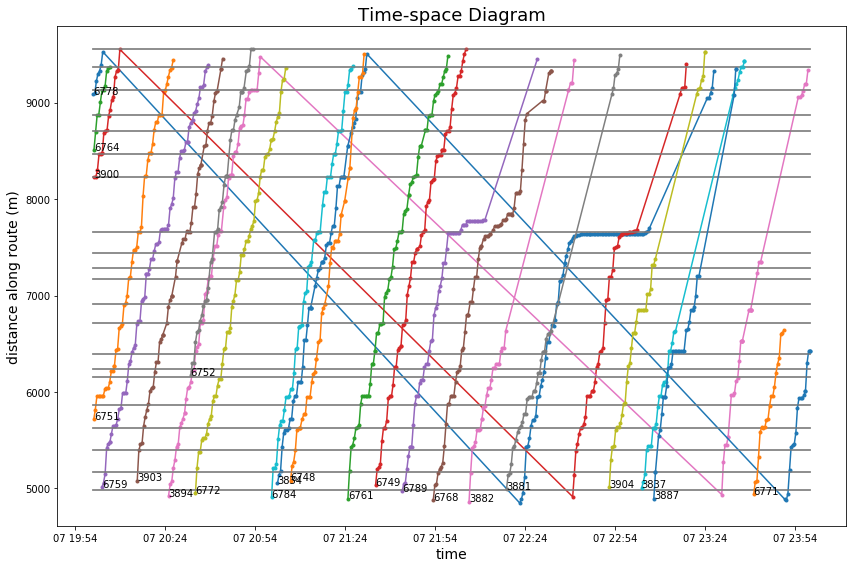

(<matplotlib.figure.Figure at 0x10e200fd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x115963be0>)

In [8]:
df = pd.read_csv("M1-train.csv")
df = df[df['DayOfWeek'] == 6]
plot_tsd(df, dir_ref=1)

In [3]:
df = pd.read_csv("data/M1-Fri-180406-154257-260.csv")
df.head()

,Unnamed: 0,Bearing,BlockRef,CallDistanceAlongRoute,DataFrameRef,DatedVehicleJourneyRef,DestinationName,DestinationRef,DirectionRef,DistanceFromCall,...,PresentableDistance,ProgressRate,ProgressStatus,PublishedLineName,RecordedAtTime,StopPointName,StopPointRef,StopsFromCall,VehicleRef,VisitNumber
0,0,53.738728,NaN,9190.62,2018-04-06,MTA NYCT_OF_B8-Weekday-087200_M1_103,HARLEM 147 ST via MADISON,MTA_803003,0,3.37,...,at stop,normalProgress,NaN,M1,2018-04-06T15:42:22.318-04:00,MADISON AV/E 121 ST,MTA_403980,0,MTA NYCT_3830,1
1,1,335.897770,MTA NYCT_OF_B8-Weekday_C_OF_22620_M1-107,12.13,2018-04-06,MTA NYCT_OF_B8-Weekday-094400_M1_142,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,8.43,...,at stop,noProgress,layover,M1,2018-04-06T15:42:25.000-04:00,MALCOLM X BL/W 146 ST,MTA_405284,0,MTA NYCT_3838,1
2,2,52.628150,MTA NYCT_OF_B8-Weekday_C_OF_25320_M1-112,491.69,2018-04-06,MTA NYCT_OF_B8-Weekday-093600_M1_138,HARLEM 147 ST via MADISON,MTA_803003,0,14.86,...,at stop,normalProgress,NaN,M1,2018-04-06T15:42:23.000-04:00,UNION SQ E/E 15 ST,MTA_404120,0,MTA NYCT_3899,1
3,3,54.062855,MTA NYCT_OF_B8-Weekday_C_OF_46800_M1-134,6925.08,2018-04-06,MTA NYCT_OF_B8-Weekday-088900_M1_134,HARLEM 147 ST via MADISON,MTA_803003,0,19.20,...,at stop,normalProgress,NaN,M1,2018-04-06T15:42:23.638-04:00,MADISON AV/E 93 ST,MTA_400039,0,MTA NYCT_3831,1
4,4,234.099460,MTA NYCT_OF_B8-Weekday_C_OF_51900_M1-141,8868.91,2018-04-06,MTA NYCT_OF_B8-Weekday-086800_M1_141,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,20.55,...,at stop,normalProgress,NaN,M1,2018-04-06T15:42:33.000-04:00,5 AV/W 45 ST,MTA_405179,0,MTA NYCT_3887,1


In [4]:
df['VehicleRef'].unique()

array(['MTA NYCT_3830', 'MTA NYCT_3838', 'MTA NYCT_3899', 'MTA NYCT_3831',
       'MTA NYCT_3887', 'MTA NYCT_3900', 'MTA NYCT_3903', 'MTA NYCT_3888',
       'MTA NYCT_3896', 'MTA NYCT_3837', 'MTA NYCT_6764', 'MTA NYCT_3881',
       'MTA NYCT_3833', 'MTA NYCT_6774', 'MTA NYCT_3894', 'MTA NYCT_6760',
       'MTA NYCT_6773', 'MTA NYCT_3898', 'MTA NYCT_6759', 'MTA NYCT_3897',
       'MTA NYCT_3884', 'MTA NYCT_6780', 'MTA NYCT_6758', 'MTA NYCT_3889',
       'MTA NYCT_6784', 'MTA NYCT_3832', 'MTA NYCT_3901', 'MTA NYCT_6771',
       'MTA NYCT_6781', 'MTA NYCT_6779', 'MTA NYCT_3891', 'MTA NYCT_6762',
       'MTA NYCT_6761', 'MTA NYCT_6777', 'MTA NYCT_6770', 'MTA NYCT_6768',
       'MTA NYCT_3902', 'MTA NYCT_3890', 'MTA NYCT_6748', 'MTA NYCT_6749',
       'MTA NYCT_6778'], dtype=object)

In [ ]:
for i, v in enumerate(df['VehicleRef'].unique()):
    # subset data for single vehicle
    veh_df = df[df['VehicleRef'] == v]

In [5]:
veh_df = df[df['VehicleRef'] == 'MTA NYCT_3900']

/Users/Yuwen/Dropbox/LTTPredict/fetchbus.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['RecordedAtTime'] = pd.to_datetime(df['RecordedAtTime'])
/Users/Yuwen/Dropbox/LTTPredict/fetchbus.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['VehDistAlongRoute'] = df['CallDistanceAlongRoute'] - df['DistanceFromCall']


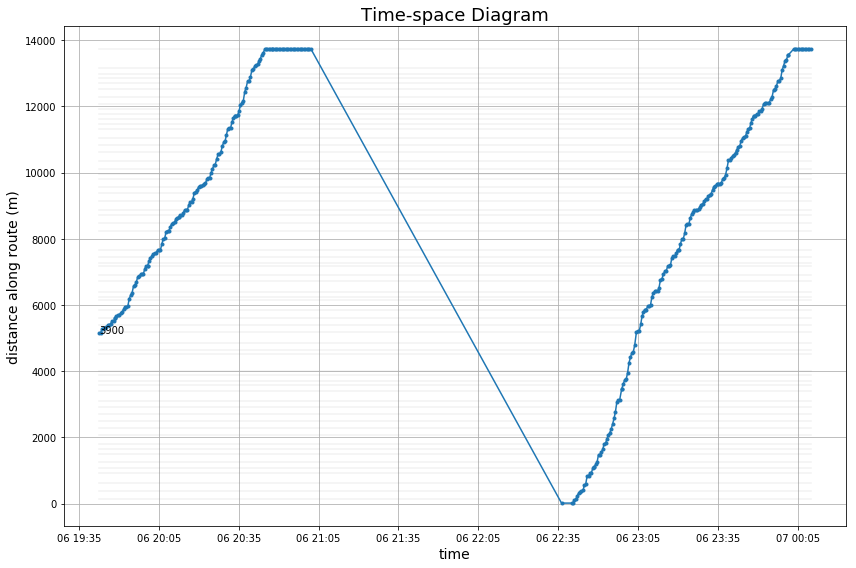

(<matplotlib.figure.Figure at 0x105f4e2b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10af37ef0>)

In [7]:
plot_tsd(veh_df, 1)

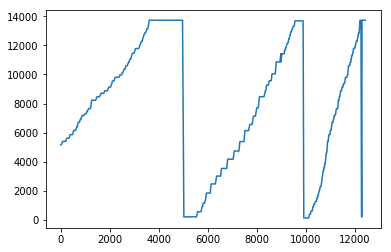

In [9]:
veh_df['CallDistanceAlongRoute'].plot()

In [12]:
veh_df['CallDistanceAlongRoute'].diff()

5             NaN
28           0.00
74         229.43
97           0.00
127          0.00
148          0.00
169          0.00
195          0.00
246        222.43
267          0.00
292          0.00
313          0.00
340          0.00
382        240.01
406          0.00
432          0.00
451          0.00
483          0.00
527        291.82
553          0.00
582          0.00
606          0.00
619         80.99
652        160.29
670          0.00
713        324.47
741          0.00
763          0.00
796        195.09
820          0.00
           ...   
12091        0.00
12096        0.00
12115      246.27
12119        0.00
12137      168.17
12147        0.00
12158      150.71
12168        0.00
12176        0.00
12193      301.06
12210      583.89
12222        0.00
12234        0.00
12243        0.00
12254        0.00
12277   -13524.14
12290        0.00
12295    13524.14
12306        0.00
12318        0.00
12331        0.00
12343        0.00
12354        0.00
12365        0.00
12376     

In [10]:
for dist in veh_df['CallDistanceAlongRoute'].diff:
    if

5         5169.49
28        5169.49
74        5398.92
97        5398.92
127       5398.92
148       5398.92
169       5398.92
195       5398.92
246       5621.35
267       5621.35
292       5621.35
313       5621.35
340       5621.35
382       5861.36
406       5861.36
432       5861.36
451       5861.36
483       5861.36
527       6153.18
553       6153.18
582       6153.18
606       6153.18
619       6234.17
652       6394.46
670       6394.46
713       6718.93
741       6718.93
763       6718.93
796       6914.02
820       6914.02
           ...   
12091    12280.26
12096    12280.26
12115    12526.53
12119    12526.53
12137    12694.70
12147    12694.70
12158    12845.41
12168    12845.41
12176    12845.41
12193    13146.47
12210    13730.36
12222    13730.36
12234    13730.36
12243    13730.36
12254    13730.36
12277      206.22
12290      206.22
12295    13730.36
12306    13730.36
12318    13730.36
12331    13730.36
12343    13730.36
12354    13730.36
12365    13730.36
12376    1